# 0) Loading Modules & Data

In [ ]:
!pip install keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, concatenate, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Embedding, Dropout
from keras.utils import to_categorical

In [ ]:
# Connecting google drive with code file
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# Changing path to project folder
%cd /content/drive/MyDrive/AutomatedEssayGrading-FYP

Mounted at /content/drive
/content/drive/MyDrive/AutomatedEssayGrading-FYP


In [ ]:
# Loading feature files
vocab_level_features_df = pd.read_csv("Data/Features/vocab_level_features_df.csv")
readability_features_df = pd.read_csv("Data/Features/readability_features_df.csv")
sentence_vectors = np.load('Data/Features/sentence_vectors_representation.npy', allow_pickle=True)
chapter_level_features_df = pd.read_csv("Data/Features/chapter_features.csv")
final_train_data = pd.read_csv("Data/Processed/final_train_data.csv")

In [ ]:
# Adding Essay Set to Vocab
vocab_level_features_df["essay_set"] = final_train_data["essay_set"]

# NUmber of Classes
num_classes = final_train_data.domain1_score.nunique()

In [ ]:
# Reshaping data
vocab_level_features_df = vocab_level_features_df.to_numpy().reshape((-1, vocab_level_features_df.shape[1], 1))
readability_features_df = readability_features_df.to_numpy().reshape((-1, readability_features_df.shape[1], 1))
chapter_level_features_df = chapter_level_features_df.to_numpy().reshape((-1, chapter_level_features_df.shape[1], 1))
sentence_vectors = np.array([i.reshape(-1, 1) for i in sentence_vectors])

targets = final_train_data['domain1_score'].values

# Spliting into training and testing sets
vocab_train, vocab_test, readability_train, readability_test, sentence_train, sentence_test, chapter_train, chapter_test, y_train, y_test = train_test_split(
    vocab_level_features_df,
    readability_features_df,
    sentence_vectors,
    chapter_level_features_df,
    targets,
    test_size=0.2,
    random_state=42
)

In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, Bidirectional, LSTM, concatenate, Flatten, Dropout
from tensorflow.keras.regularizers import l2

# Model builder function
def model_builder(hp):
    # Hyperparameters to test
    vocab_filters = hp.Int('vocab_filters', min_value=32, max_value=64, step=16)
    read_filters = hp.Int('read_filters', min_value=16, max_value=64, step=16)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dense_units = hp.Int('dense_units', min_value=8, max_value=64, step=8)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.4, step=0.1)
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4])
    reg_factor = hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='log')

    regularizer = l2(reg_factor)

    # Inputs
    vocab_input = Input(shape=(vocab_train.shape[1], 1), name='vocab_level_input')
    read_input = Input(shape=(readability_train.shape[1], 1), name='readability_input')
    sentence_input = Input(shape=(sentence_train.shape[1], 1), name='sentence_vector_input')
    chapter_input = Input(shape=(chapter_train.shape[1], 1), name='chapter_level_input')

    # CNN for Vocabulary Level
    x_vocab = Conv1D(filters=vocab_filters, kernel_size=3, activation='relu', kernel_regularizer=regularizer)(vocab_input)
    x_vocab = Conv1D(filters=vocab_filters, kernel_size=3, activation='relu', kernel_regularizer=regularizer)(x_vocab)
    x_vocab = Dropout(dropout_rate)(x_vocab)
    x_vocab = Flatten()(x_vocab)

    # CNN for Readability
    x_read = Conv1D(filters=read_filters, kernel_size=3, activation='relu', kernel_regularizer=regularizer)(read_input)
    x_read = Conv1D(filters=read_filters, kernel_size=3, activation='relu', kernel_regularizer=regularizer)(x_read)
    x_read = Dropout(dropout_rate)(x_read)
    x_read = Flatten()(x_read)

    # BiLSTM for Sentence Vectors
    x_sentence = Bidirectional(LSTM(lstm_units, return_sequences=True, kernel_regularizer=regularizer))(sentence_input)
    x_sentence = Bidirectional(LSTM(lstm_units, kernel_regularizer=regularizer))(x_sentence)

    # Combine Readability and Sentence
    fusion_1 = concatenate([x_read, x_sentence])

    # BiLSTM for Chapter Level
    x_chapter = Bidirectional(LSTM(lstm_units, return_sequences=True, kernel_regularizer=regularizer))(chapter_input)
    x_chapter = Bidirectional(LSTM(lstm_units, kernel_regularizer=regularizer))(x_chapter)

    # Final fusion
    final_fusion = concatenate([x_vocab, fusion_1, x_chapter])

    # Dense Layers
    dense = Dense(dense_units, activation='relu', kernel_regularizer=regularizer)(final_fusion)
    dense = Dropout(dropout_rate)(dense)
    output = Dense(1, kernel_regularizer=regularizer)(dense)

    # Build model
    model = Model(inputs=[vocab_input, read_input, sentence_input, chapter_input], outputs=output)

    # Compile
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mae', metrics=["mse", "mae"])

    return model

# ---------------------------
# Hyperparameter Search Setup
# ---------------------------
tuner = kt.RandomSearch(
    model_builder,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    directory='tuning_dir',
    project_name='fusion_model_low_values'
)

# Callback to stop early if no improvement
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Reshape inputs for model compatibility
vocab_train_r = vocab_train[:, :, np.newaxis]
vocab_test_r = vocab_test[:, :, np.newaxis]
readability_train_r = readability_train[:, :, np.newaxis]
readability_test_r = readability_test[:, :, np.newaxis]
sentence_train_r = np.array(sentence_train.tolist())[:, :, np.newaxis]
sentence_test_r = np.array(sentence_test.tolist())[:, :, np.newaxis]
chapter_train_r = chapter_train[:, :, np.newaxis]
chapter_test_r = chapter_test[:, :, np.newaxis]

# Run tuning
tuner.search(
    [vocab_train_r, readability_train_r, sentence_train_r, chapter_train_r],
    y_train,
    validation_data=([vocab_test_r, readability_test_r, sentence_test_r, chapter_test_r], y_test),
    epochs=20,
    batch_size=64,
    callbacks=[stop_early]
)

# ---------------------------
# Get the Best Model
# ---------------------------
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Summary of best model
best_model.summary()

Reloading Tuner from tuning_dir/fusion_model_low_values/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 74 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ readability_input         │ (None, 29, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vocab_level_input         │ (None, 28, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 27, 64)         │            256 │ readability_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 26, 32)         │            128 │ vocab_level_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 25, 64)         │         12,352 │ conv1d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentence_vector_input     │ (None, 100, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 24, 32)         │          3,104 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 25, 64)         │              0 │ conv1d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 100, 256)       │        133,120 │ sentence_vector_input… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ chapter_level_input       │ (None, 71, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 24, 32)         │              0 │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 1600)           │              0 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 256)            │        394,240 │ bidirectional[0][0]    │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, 71, 256)        │        133,120 │ chapter_level_input[0… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 768)            │              0 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1856)           │              0 │ flatten_1[0][0],       │
│                      

 Total params: 1,208,897 (4.61 MB)

 Trainable params: 1,208,897 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
best_hp

In [ ]:
# Regularization strength
regularizer = l2(0.001)

# Define the inputs
vocab_level_input = Input(shape=(vocab_level_features_df.shape[1], 1), name='vocab_level_input')
readability_input = Input(shape=(readability_features_df.shape[1], 1), name='readability_input')
sentence_vector_input = Input(shape=(sentence_vectors[0].shape[0], 1), name='sentence_vector_input')
chapter_level_input = Input(shape=(chapter_level_features_df.shape[1], 1), name='chapter_level_input')

# CNN for vocabulary level features
cnn_vocab_level = Conv1D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=regularizer)(vocab_level_input)
cnn_vocab_level = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=regularizer)(cnn_vocab_level)
cnn_vocab_level = Dropout(0.2)(cnn_vocab_level)
cnn_vocab_level = Flatten()(cnn_vocab_level)

# CNN for readability
cnn_readability = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=regularizer)(readability_input)
cnn_readability = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=regularizer)(cnn_readability)
cnn_readability = Dropout(0.2)(cnn_readability)
cnn_readability = Flatten()(cnn_readability)

# BiLSTM for sentence vectors
lstm_sentence_vector = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=regularizer))(sentence_vector_input)
lstm_sentence_vector = Bidirectional(LSTM(64, kernel_regularizer=regularizer))(lstm_sentence_vector)

# First fusion
fusion_1 = concatenate([cnn_readability, lstm_sentence_vector])

# BiLSTM for chapter level features
lstm_chapter_level = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=regularizer))(chapter_level_input)
lstm_chapter_level = Bidirectional(LSTM(128, kernel_regularizer=regularizer))(lstm_chapter_level)

# Final fusion
final_fusion = concatenate([cnn_vocab_level, fusion_1, lstm_chapter_level])

# Output layers with regularization
output = Dense(16, activation='relu', kernel_regularizer=regularizer)(final_fusion)
output = Dense(1, activation='linear', kernel_regularizer=regularizer)(output)

# Build model
model = Model(
    inputs=[vocab_level_input, readability_input, sentence_vector_input, chapter_level_input],
    outputs=output
)

# Show model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ readability_input         │ (None, 29, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vocab_level_input         │ (None, 28, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 27, 64)         │            256 │ readability_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 26, 32)         │            128 │ vocab_level_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 25, 64)         │         12,352 │ conv1d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentence_vector_input     │ (None, 100, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 24, 64)         │          6,208 │ conv1d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 25, 64)         │              0 │ conv1d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_4           │ (None, 100, 128)       │         33,792 │ sentence_vector_input… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ chapter_level_input       │ (None, 71, 1)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 24, 64)         │              0 │ conv1d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 1600)           │              0 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 128)            │         98,816 │ bidirectional_4[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_6           │ (None, 71, 256)        │        133,120 │ chapter_level_input[0… │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_2 (Flatten)       │ (None, 1536)           │              0 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 1728)           │              0 │ flatten_3[0][0],       │
│ (Concatenate)        

 Total params: 735,265 (2.80 MB)

 Trainable params: 735,265 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

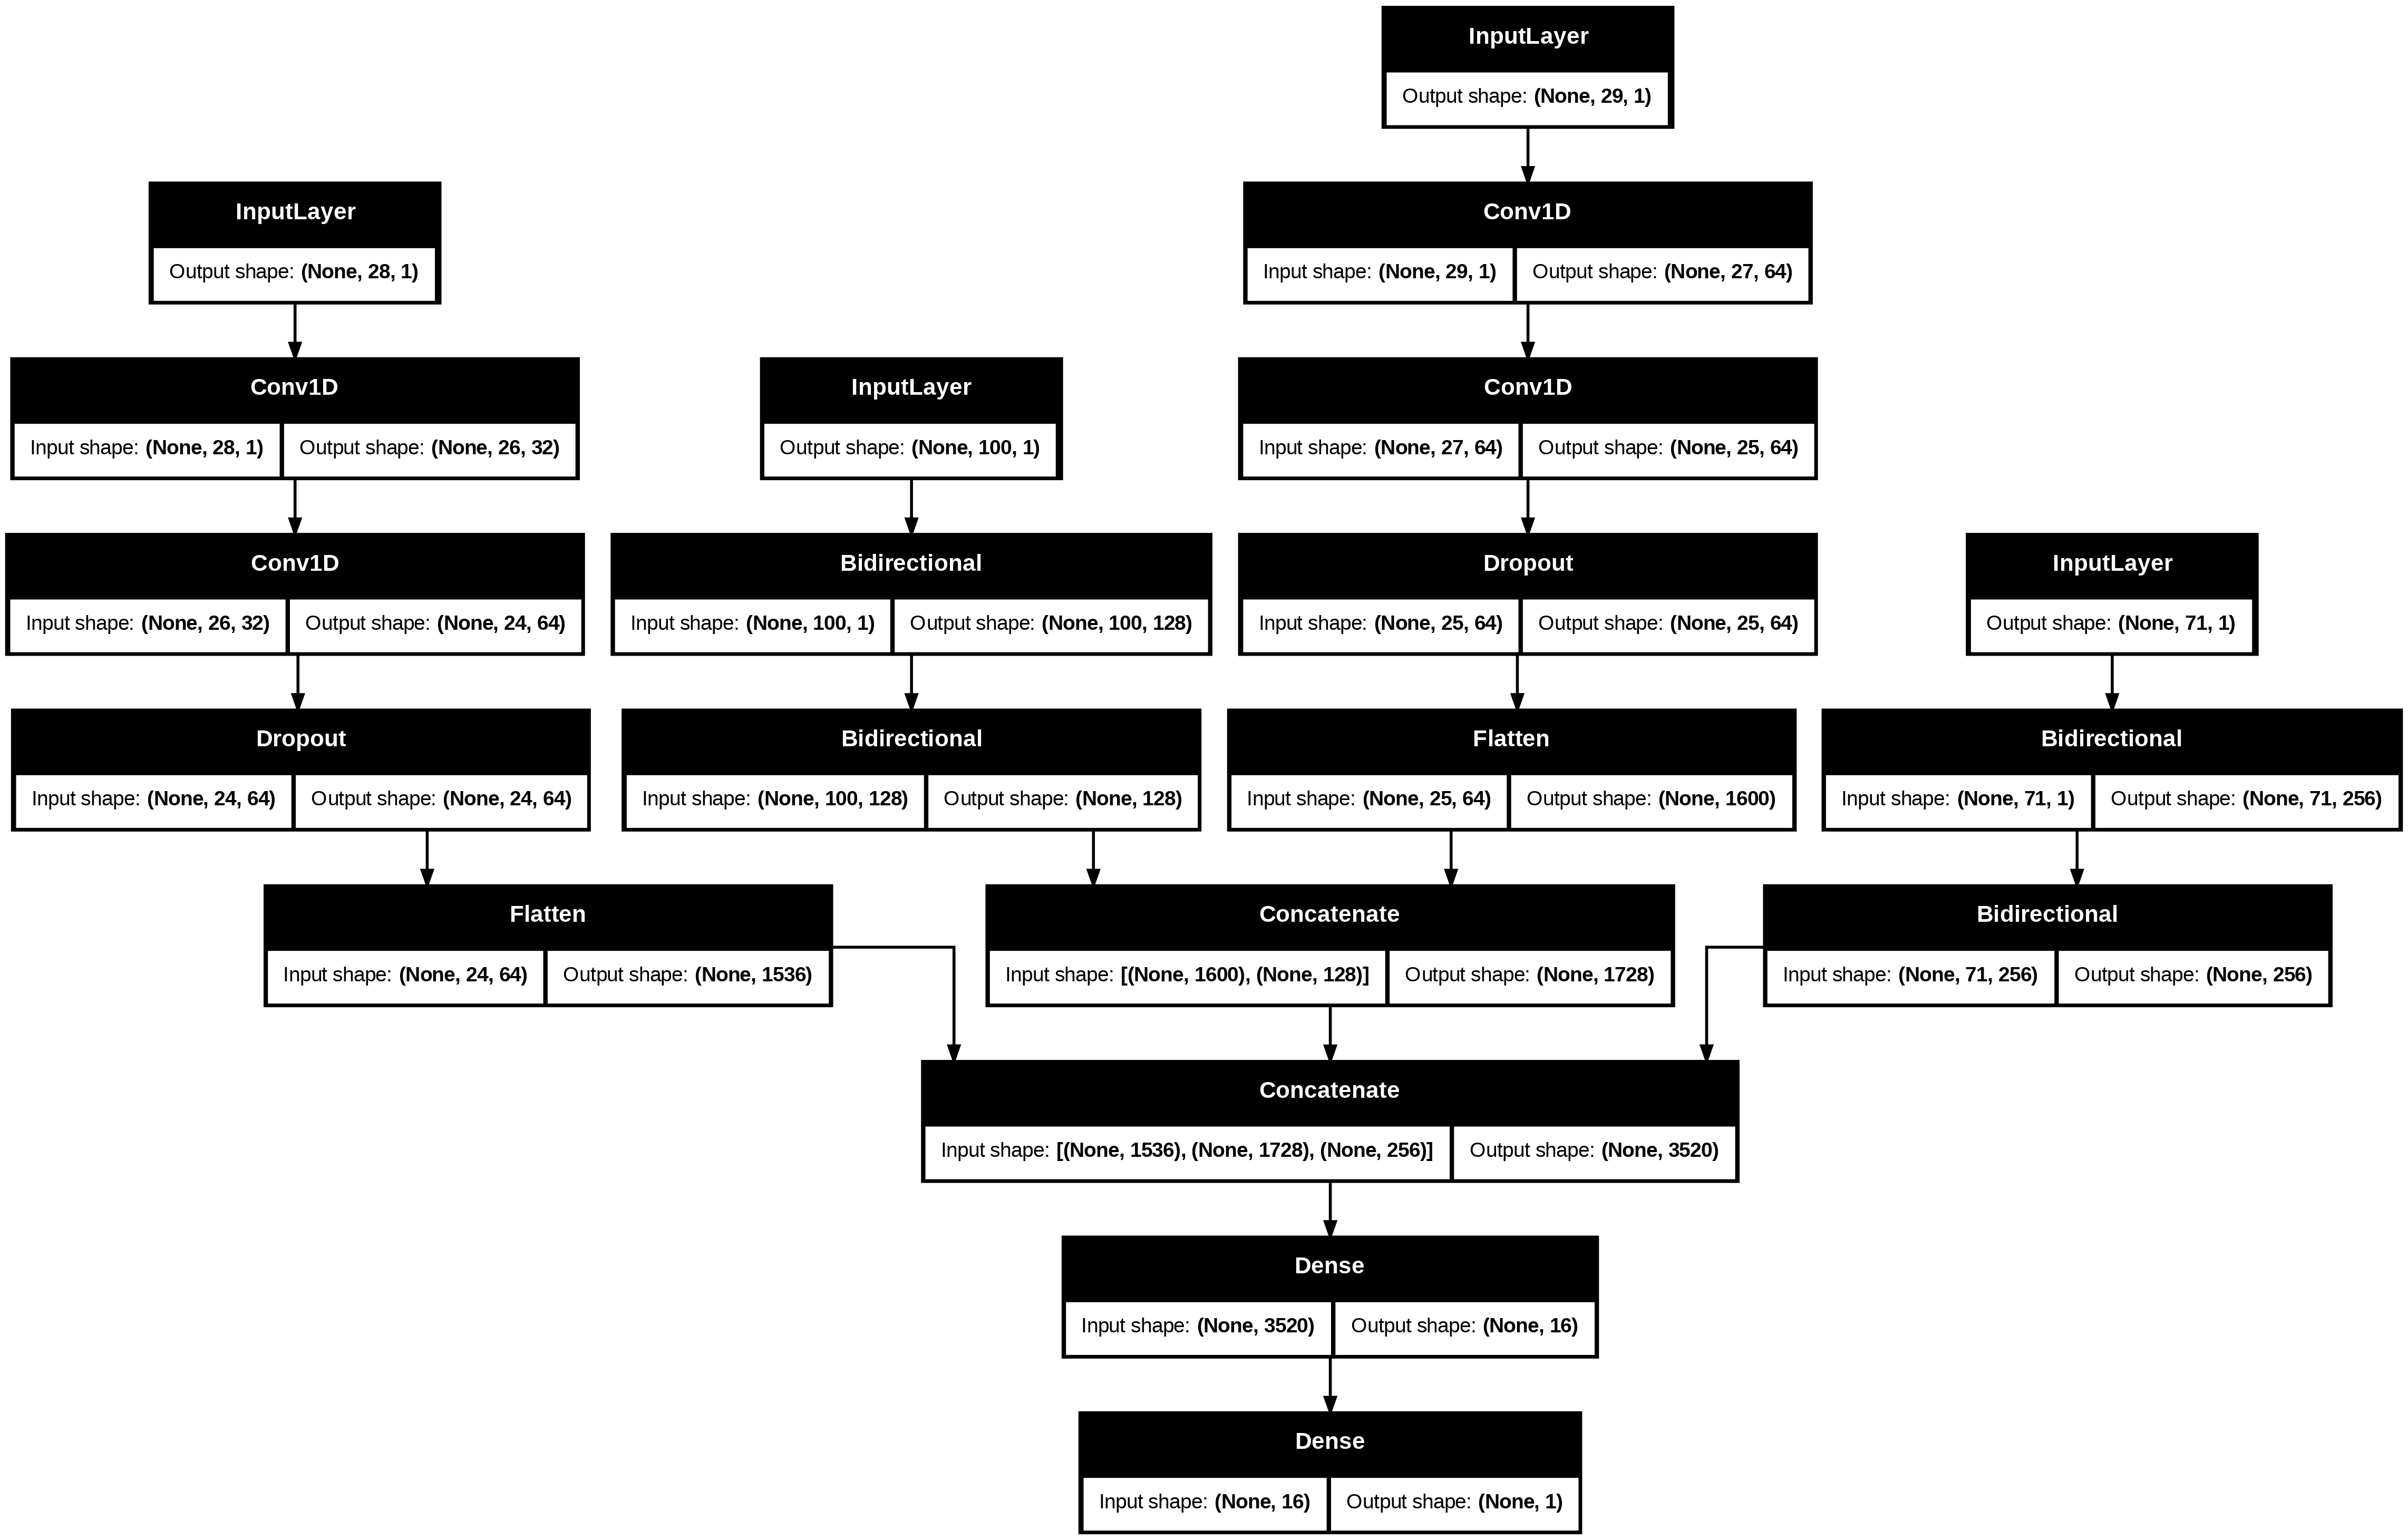

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# Compiling the model with a custom loss function and optimizer
model.compile(optimizer='adam', loss='mae', metrics=["mse", "mae"])

# Training the model
history = model.fit(
    [vocab_train, readability_train, sentence_train, chapter_train],
    y_train,
    validation_data=([vocab_test, readability_test, sentence_test, chapter_test], y_test),
    batch_size=128,
    epochs=50
)

Epoch 1/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - loss: 8.1134 - mae: 7.3330 - mse: 174.6935 - val_loss: 3.5914 - val_mae: 3.3927 - val_mse: 41.4343
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 3.6391 - mae: 3.4725 - mse: 43.0252 - val_loss: 2.8820 - val_mae: 2.7564 - val_mse: 28.4444
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 3.1262 - mae: 3.0014 - mse: 34.1120 - val_loss: 2.7170 - val_mae: 2.5906 - val_mse: 24.3689
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 2.9557 - mae: 2.8292 - mse: 31.1843 - val_loss: 2.7829 - val_mae: 2.6559 - val_mse: 27.7062
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 2.7369 - mae: 2.6038 - mse: 27.0224 - val_loss: 2.3773 - val_mae: 2.2273 - val_mse: 18.7384
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 2.4618 - mae: 2.3117 - mse: 20.3244 - val_loss: 2.2542 - val_mae: 2.0954 - val_mse: 15.2404
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 2.1720 - mae: 2.0092 - mse: 14.66

In [ ]:
# Saving Trained Model for Later Use
model.save("Outputs/trained_model.keras")

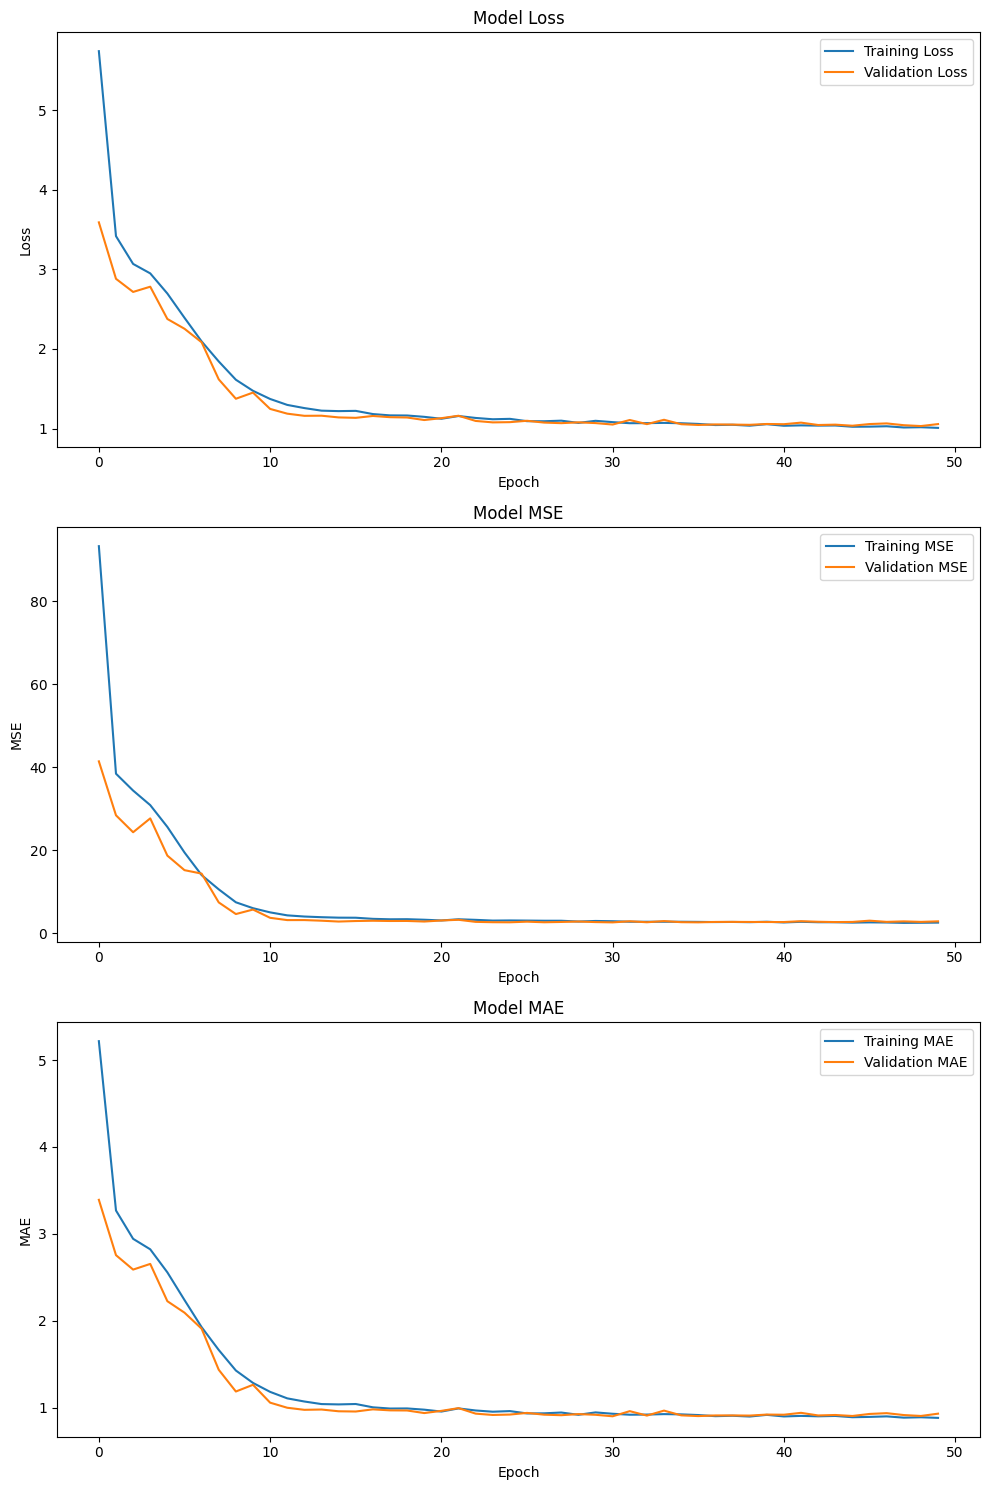

In [ ]:
import matplotlib.pyplot as plt

# Plotting the history of the model
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Model Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# MSE
axs[1].plot(history.history['mse'], label='Training MSE')
axs[1].plot(history.history['val_mse'], label='Validation MSE')
axs[1].set_title('Model MSE')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MSE')
axs[1].legend()

# MAE
axs[2].plot(history.history['mae'], label='Training MAE')
axs[2].plot(history.history['val_mae'], label='Validation MAE')
axs[2].set_title('Model MAE')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('MAE')
axs[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Making Prediction
y_pred = model.predict([vocab_test, readability_test, sentence_test, chapter_test], verbose=0)
y_pred = list(y_pred[:, 0])
y_test = list(y_test)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, cohen_kappa_score

# Calculating metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rounded_predictions = [round(pred) for pred in y_pred] # Rounding predictions for QWK
qwk = cohen_kappa_score(y_test, rounded_predictions, weights='quadratic')

print("MSE:", mse)
print("MAE:", mae)
print("R2 Score:", r2)
print("QWK:", qwk)

MSE: 2.9217617045178628
MAE: 0.9343962113276836
R2 Score: 0.9624731417035265
QWK: 0.9810349360564377


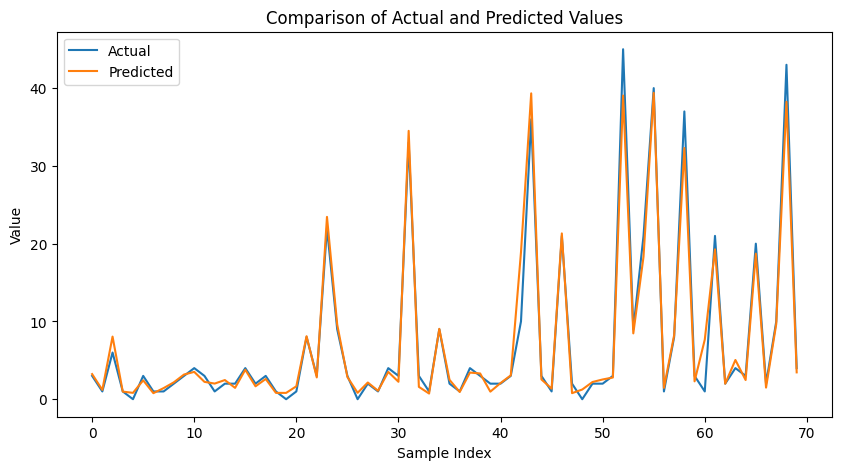

In [ ]:
# Plotting the 100 samples from test and pred as lines
plt.figure(figsize=(10, 5))
plt.plot(y_test[30:100], label='Actual')
plt.plot(y_pred[30:100], label='Predicted')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
df_pred = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
df_pred.to_csv("predictions.csv", index=False)
df_pred.iloc[30:40]

,Actual,Predicted
30,3,3.231125
31,1,1.201054
32,6,8.052955
33,1,0.979721
34,0,0.818309
35,3,2.428552
36,1,0.778574
37,1,1.429467
38,2,2.172474
39,3,3.174241
